# Analisis Sentimen Notebook

Melakukan analisis sentimen pada data hasil crawling

## 1. Import Libraries

Import library yang akan digunakan

In [1]:
import os, re, string, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## 2. Load Dataset

Load data ke memmory menggunakan library pandas.

In [2]:
data1 = pd.read_csv("../data/Crawling Twitter Jakarta 26 - 27.csv")
data2 = pd.read_csv("../data/Crawling Twitter Jakarta 25 - 23.csv")
data3 = pd.read_csv("../data/Crawling Twitter Jakarta 22 - 19 setengah.csv")

**Menggabungkan data**

Menggabungkan 3 dataset tersebut menjadi satu

In [3]:
# Concate data
data = pd.concat([data1, data2, data3])
data.head()

,Tanggal,Tweets,ID,Screen Name,Banyak Retweet,Source,Retweet Status,Hashtags
0,2020-04-27 23:59:57,b'RT @ayanggwiwid: Bayangin kalo pabrik skinca...,1254923268621955072,vinnmuth,336,Twitter for Android,1,[]
1,2020-04-27 23:59:57,b'RT @okezonenews: Wali Kota Palangkaraya Posi...,1254923270333231105,Nila_Widuri,4,Twitter for Android,1,"['TauCepatTanpaBatas', 'BeritaTerkini', 'Berit..."
2,2020-04-27 23:59:56,b'RT @detikcom: Pemerintah negara bagian New S...,1254923263584514048,nafisines,12,Twitter for iPhone,1,[]
3,2020-04-27 23:59:52,b'RT @hilmi_fpi: Proses pngmasan pkt sahur ole...,1254923248657035265,Tengsyut07,285,Twitter for Android,1,[]
4,2020-04-27 23:59:49,b'RT @ulil: Kepada para anggota DPR: Jangan ke...,1254923236346720257,ChumaerohLaeli,665,Twitter Web App,1,[]


In [4]:
# Cleanner
def cleaning(text):
    text = text[2:]
    text = text.replace("\\n", " ")
    return text

In [5]:
data["Tweets"] = data["Tweets"].apply(lambda x: cleaning(x))
data["Tweets"].values

array(["RT @ayanggwiwid: Bayangin kalo pabrik skincare ditutup gara gara corona, burik burik dah lu pada.'",
       "RT @okezonenews: Wali Kota Palangkaraya Positif Terjangkit Virus Corona   #TauCepatTanpaBatas #BeritaTerkini #BeritaDaerah . https://t.co/z\\xe2\\x80\\xa6'",
       "RT @detikcom: Pemerintah negara bagian New South Wales, Australia memindahkan ribuan warga tunawisma di negara bagiannya untuk tinggal di h\\xe2\\x80\\xa6'",
       ...,
       "RT @hsuf: Jika Indonesia ternyata berhasil melalui masa wabah ini dengan sukses, minim korban - #seperti dengan berbagai panduan dari @Kawa\\xe2\\x80\\xa6'",
       "RT @Aryprasetyo85: Semoga pemda nya gk tutup mata dan membantu keluarga ini  Memprihatinkan!! Satu Keluarga Kelaparan Tak Makan 2 Hari Kare\\xe2\\x80\\xa6'",
       "RT @Fahrihamzah: Politic &amp; Decision Making Penanganan COVID-19 https://t.co/UrFWlFXWHz'"],
      dtype=object)

## 2. Data Preprocessing

Preprocess data text sebelum diolah

## 2.1. Stemmer

> Stemming merupakan suatu proses untuk menemukan kata dasar dari sebuah kata. Dengan menghilangkan semua imbuhan (affixes) baik yang terdiri dari awalan (prefixes), sisipan (infixes), akhiran (suffixes) dan confixes (kombinasi dari awalan dan akhiran) pada kata turunan. Stemming digunakan untuk mengganti bentuk dari suatu kata menjadi kata dasar dari kata tersebut yang sesuai dengan struktur morfologi Bahasa Indonesia yang baik dan benar.

Membuat Stemmer menggunakan sastrawi.

In [6]:
# Create Sastrawi stemmer
stemmer = StemmerFactory().create_stemmer()

## 2.2. Stopwords

> Stop words adalah kata umum (common words) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

Akan dibuat list yang berisi stopword yang ada pada bahasa indonesia.

In [7]:
# Create Stopword
with open("../kamus/Stopword.txt", "r") as f:
    stop_words = f.readline()
    stop_words = stop_words.split()

## 2.3. Preprocessing function

Akan dilakukan beberapa tahap untuk preprocess data text agar siap digunakan, yaitu:

1. Normalisasi karakter string menjadi huruf kecil
2. Menghapus emoji
3. Menghapus setiap url
4. Menghapus tagging
5. Menghapus whitespace
6. Menghapus simbol '#' pada hashtag
7. Menghapus angka
8. Mengganti tanda baca menjadi '<spasi>'

In [8]:
# Preprocessor
def preprocessor(text):
    # Convert to lower case
    text = text.lower()
    # Remove additional code
    text = text.replace("\\xe2\\x80\\xa6", "")
    # Convert www.* or https?://* to URL
    text = re.sub("((www\.[^\s]+)|(https?://[^\s]+))", "", text)
    # Convert @username to AT_USER
    text = re.sub("@[^\s]+", "", text)
    # Remove additional white spaces
    text = re.sub("[\s]+", " ", text)
    # Replace #word with word
    text = re.sub(r"#([^\s]+)", r"\1", text)
    # Menghapus angka dari teks
    text = re.sub(r"\d+", "", text)
    # Menganti tanda baca dengan spasi
    text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    return text

In [9]:
data["Tweets"] = data["Tweets"].apply(lambda x: preprocessor(x))
data["Tweets"].values

array(['rt bayangin kalo pabrik skincare ditutup gara gara corona  burik burik dah lu pada  ',
       'rt wali kota palangkaraya positif terjangkit virus corona taucepattanpabatas beritaterkini beritadaerah   ',
       'rt pemerintah negara bagian new south wales  australia memindahkan ribuan warga tunawisma di negara bagiannya untuk tinggal di h ',
       ...,
       'rt jika indonesia ternyata berhasil melalui masa wabah ini dengan sukses  minim korban   seperti dengan berbagai panduan dari ',
       'rt semoga pemda nya gk tutup mata dan membantu keluarga ini memprihatinkan   satu keluarga kelaparan tak makan  hari kare ',
       'rt politic  amp  decision making penanganan covid  '],
      dtype=object)

## 2.4. Tokenizer

Membuat custom tokenizer menggunakan `word_tokenize` dari library `nltk` lalu memfilter token tersebut.

In [10]:
# Tokenizer
def tokenizer(text):
    words = word_tokenize(text)
    tokens = []
    for w in words:
        # add tokens
        if len(w) > 3 and w not in stop_words:
            w = stemmer.stem(w)
            tokens.append(w.lower())
    return " ".join(tokens)

In [11]:
# Untuk menghemat waktu running dilakukan loading tweet yang sudah
# dibersihkan sebelumnya
with open("../data/cleaned-tweets.txt") as reader:
    data["Tweets"] = reader.read().split("\n")

# Uncomment dan run kode di bawah jika mengganti atau menambahkan
# metode preprocess data text, proses running membutuhkan waktu
# yang cukup lama (sekitar 1 jam)
# data['Tweets'] = data['Tweets'].apply(lambda x : tokenizer(x))

data["Tweets"].values

array(['bayangin kalo pabrik skincare tutup gara gara corona burik burik',
       'wali kota palangkaraya positif jangkit virus corona taucepattanpabatas beritaterkini beritadaerah',
       'perintah negara south wales australia pindah ribu tunawisma negara bagi tinggal',
       ..., 'indonesia hasil wabah sukses minim korban pandu',
       'moga pemda tutup mata bantu keluarga prihatin keluarga lapar makan kare',
       'politic decision making tangan covid'], dtype=object)

## 2.5. Text Vectorization

Text vectorization adalah cara melakukan encode data text menjadi numerik. Berikut akan dilakukan vectorization menggunakan `TfidfVectorizer` dari library `scikit-learn`. Untuk mempelajari text vectorization lebih lanjut dapat membaca artikel [berikut](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

In [12]:
# Defining Vectorizer object
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# Load saved vectorizer
# vectorizer_tfidf = pickle.load(open('../model/vectorizer/vectorizer_tfidf.pickle', 'rb'))

**fit & transform**

Ubah data text menjadi encoded matrix

In [13]:
# fit and transform text data
word_tfidf = vectorizer_tfidf.fit_transform(data["Tweets"].values)
word_tfidf

<250279x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3595289 stored elements in Compressed Sparse Row format>

Mengambil nama fitur / kata - kata yang terdapat dalam data dan melihat dimensi data setelah dilakukan vectorization menggunakan `TfidfVectorizer`

In [14]:
# Nama fitur
nama_fitur = vectorizer_tfidf.get_feature_names_out()

# Dimensi data
dimensions = word_tfidf.get_shape()
print(f"Jumlah artikel = {dimensions[0]}")
print(f"Jumlah fitur   = {dimensions[1]}")

Jumlah artikel = 250279
Jumlah fitur   = 10000


## 2.6. Kata dengan bobot TF-IDF tertinggi

Melihat kata - kata dengan bobot TF-IDF tertinggi

In [15]:
content1, content2 = [], []

for n in range(dimensions[0]):
    # Convert sparse matrix row by row
    row = word_tfidf.getrow(n).toarray()[0].ravel()
    # Get top values and its indexes
    top_ten_indices = row.argsort()[-1]
    top_ten_values = row[row.argsort()[-1]]
    # Identify the highest TFIDF value and word #
    highestTFIDFword = nama_fitur[top_ten_indices]
    highestTFIDFvalue = top_ten_values
    top1word = {
        "nomor artikel": n + 1,
        "nilai TFIDF": highestTFIDFvalue,
        "top word": highestTFIDFword,
    }
    content1.append(top1word)
    content2.append(highestTFIDFword)

# Hitung Frekuiensi kata dengan bobot terbesar
content2 = np.asarray(content2)
words, n = np.unique(content2, return_counts=True)

# Convert to DataFrame lalu urutkan secara descending
# lalu pilih 20 kata dengan frekuensi terbesar
words_data = (
    pd.DataFrame({"Kata": words, "Banyak": n}).sort_values(by="Banyak", ascending=False).head(20)
)
words_data

,Kata,Banyak
1958,fatwa shalat,20656
2015,gadis,5523
4710,plasma,5522
4717,please dude,4617
3608,lupa,4298
2961,karyawan turun,3255
5014,ramadan sembari,2589
5575,semenjak covi,2315
2636,jagajar,2193
4960,pusat pol,2038


**Visualisasi hasil**

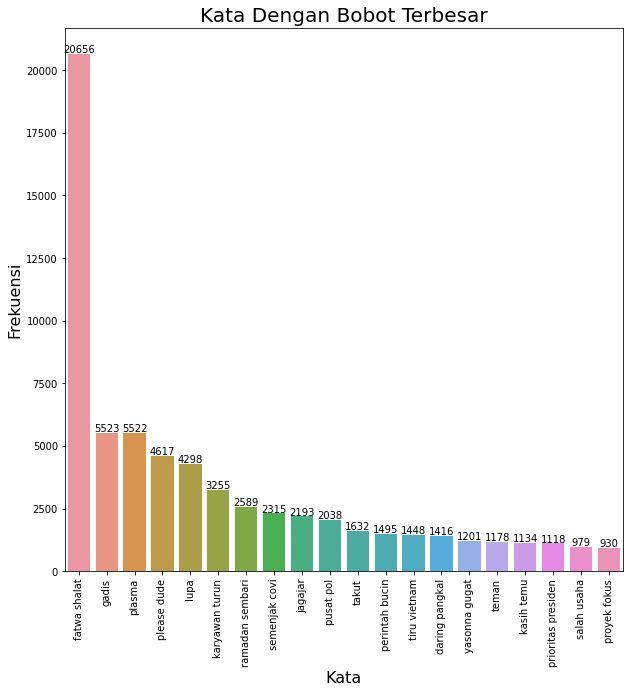

In [16]:
# Plotting Barplot
plt.figure(figsize=(10, 10))
sns.barplot(x=words_data["Kata"], y=words_data["Banyak"])
for i, v in enumerate(words_data["Banyak"].tolist()):
    plt.text(i - len(str(v)) / 10 - 0.05, v + 50, str(v), fontsize=10)
plt.title("Kata Dengan Bobot Terbesar", fontsize=20)
plt.xticks(rotation=90)
plt.xlabel("Kata", fontsize=16)
plt.ylabel("Frekuensi", fontsize=16)
plt.show()

## 3. Pemodelan

Akan dilakukan pemodelan menggunakan beberapa metode machine learning seperti:

1. Decision Tree
2. Logistic Regression
3. Random Forest Classifier
4. Support Vector Machine

Lalu performa model - model tersebut akan dibandingkan dengan melihat metric `accuracy` untuk dipilih sebagai model terbaik.

## 3.1. Loading Sample Data

Karena untuk melakukan pemodelan dengan motode - metode yang telah di jabarkan memerlukan label (`y`) sedangkan data hasil crawling tidak memiliki label (`y`). Maka perlu dilakukan labeling secara manual dengan ketentuan:

* `0` adalah label untuk tweet yang bersentimen `negatif`
* `1` adalah label untuk tweet yang bersentimen `netral`
* `2` adalah label untuk tweet yang bersentimen `positif`

Karena jika menggunakan seluruh data yang di crawl untuk dilakukan labelng secara manual membutuhkan waktu dan tenaga yang besar (karena jumlah datanya sangat banyak), maka perlu dilakukan sampling terhadap dataset untuk mengambil sebagian data. Pada notebook ini akan digunakan dataset hasil sampling data dan telah dilakukan labeling secara manual oleh penulis, untuk proses samplingnya dapat dilihat pada notebook `Sampling.ipynb`

In [17]:
# Loading Sample tweet sentiment
sample = pd.read_csv("../data/Sample Tweet.csv")
sample.head()

,Index,Tweets,Sentiment
0,51365,b'Salut! Polri mendapat apresiasi dari DPR RI ...,2
1,94963,b'Sebelum booming corona biasanya ke pasar non...,0
2,16832,b'Covid 19 plus 30 ribu narapidana https://t.c...,0
3,29905,"b'@faruqhmd Lu corona ora, muntaber iya.'",0
4,25279,b'3. Jenazah belum dapat dipastikan apakah pos...,1


## 3.2. Preprocess Sampling dataset

Encode kolom `Tweets` pada sampling dataset dengan menggunakan `TfidfVectorizer` yang sebelumnya. Lalu extract `x` dan `y` dari dataframe

In [18]:
sample["Tweets"] = sample["Tweets"].apply(lambda x: cleaning(x))
sample["Tweets"] = sample["Tweets"].apply(lambda x: preprocessor(x))
sample["Tweets"] = sample["Tweets"].apply(lambda x: tokenizer(x))
sample["Tweets"].values[:5]

array(['salut polri apresiasi tegak hukum laku tindak kriminal pandemi covid dprriapresiasipolri',
       'booming corona pasar nongkrong mamang mamang sunda bincang dunia empon bogor skrg atulah pasar happy pasar piknik mother children',
       'covid plus ribu narapidana', 'corona muntaber',
       'jenazah positif infeksi covid hasil swab proses pemulasaraan makam jenazah sesuai prosedur protap covid'],
      dtype=object)

In [19]:
x = vectorizer_tfidf.transform(sample["Tweets"].values)
y = sample["Sentiment"].values

**Splitting Data**

Membagi data menjadi data `train` dan data `valid` dengan perbandingan `80:20`

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=2020)

## 3.3. Fitting Model

Akan dilakukan fitting model - model terhadap data `train` lalu model - model tersebut akan diukur keakuratannya dengan menghitung akurasinya pada data `valid`

In [21]:
# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics

classifiers = {
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=2020),
    "Logistic Regression": LogisticRegression(random_state=2020),
    "Random Forest Classifier": RandomForestClassifier(random_state=2020),
    "SVM": SVC(kernel="linear", probability=True, random_state=2020),
}

for name in classifiers.keys():
    classifiers[name].fit(x_train, y_train)
    y_pred = classifiers[name].predict(x_valid)
    print(f"Akurasi dari {name} : ", metrics.accuracy_score(y_valid, y_pred))

Akurasi dari Decision Tree Classifier :  0.5
Akurasi dari Logistic Regression :  0.5928571428571429
Akurasi dari Random Forest Classifier :  0.6
Akurasi dari SVM :  0.6071428571428571


**Insight**

Dapat dilihat bahwa `SVM` memiliki performa yang jauh lebih baik dari model - model yang lain. Maka dari itu model `SVM` akan digunakan untuk memprediksi keseluruhan data

## 4. Prediction (Peramalan)

Akan dilakukan peramalan terhadap keseluruhan data menggunakan medel `SVM` yang telah di fit sebelumnya

In [22]:
data["prediction"] = classifiers["SVM"].predict(word_tfidf)
data.head()

,Tanggal,Tweets,ID,Screen Name,Banyak Retweet,Source,Retweet Status,Hashtags,prediction
0,2020-04-27 23:59:57,bayangin kalo pabrik skincare tutup gara gara ...,1254923268621955072,vinnmuth,336,Twitter for Android,1,[],1
1,2020-04-27 23:59:57,wali kota palangkaraya positif jangkit virus c...,1254923270333231105,Nila_Widuri,4,Twitter for Android,1,"['TauCepatTanpaBatas', 'BeritaTerkini', 'Berit...",1
2,2020-04-27 23:59:56,perintah negara south wales australia pindah r...,1254923263584514048,nafisines,12,Twitter for iPhone,1,[],1
3,2020-04-27 23:59:52,proses pngmasan sahur msak taqi hilmi menu sah...,1254923248657035265,Tengsyut07,285,Twitter for Android,1,[],1
4,2020-04-27 23:59:49,anggota dapil pliiiiiiiiissss bantu jakarta daer,1254923236346720257,ChumaerohLaeli,665,Twitter Web App,1,[],2


## 5. Visualization

Visualisasi sentimen hasil predisian model `SVM`

## 5.1. Perbandingan Sentimen

Perbandingan jumlah antar sentimen yang ada

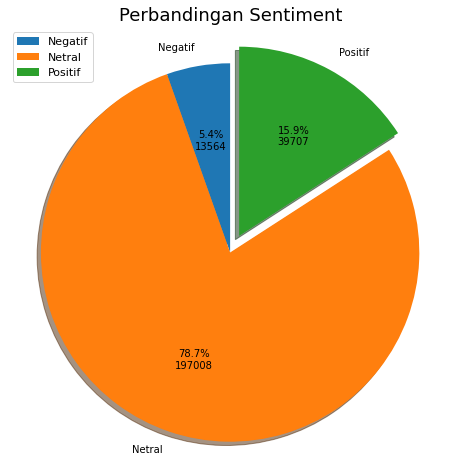

In [23]:
# Plotting Pie
def pct_pie(pct, allvals):
    absolute = int(pct / 100.0 * np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)


sentimen = data["Tweets"].groupby(data["prediction"]).count().values

plt.figure(figsize=(8, 8))
plt.pie(
    sentimen,
    explode=(0, 0, 0.1),
    labels=["Negatif", "Netral", "Positif"],
    shadow=True,
    autopct=lambda pct: pct_pie(pct, sentimen),
    startangle=90,
)
plt.title("Perbandingan Sentiment", fontsize=18)
plt.axis("equal")
plt.legend(fontsize=11)
plt.show()

**Insight**

Dapat dilihat dari pie chart di atas bahwa pada rentang 19 - 27 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan positif jauh lebih banyak dari tweet yang bermuatan negatif sedangkan tweet yang bermuatan netral jauh melampaui keduanya.

## 5.2. Tweet perhari Berdasarkan Sentimen

Akan dilihat perbandingan tweet perharinya dari tanggal 19 - 27 April 2020 berdasarkan sentimennya

In [24]:
# Melihat banyak Tweet perhari berdasarkan sentiment
data["Tanggal"] = pd.to_datetime(data["Tanggal"])
tph = data["Tweets"].groupby([data["Tanggal"].dt.date, data["prediction"]]).count()
frek = tph.values

# To Data Frame
tanggal = [i for i, j in tph.index.tolist()]
senti = [j for i, j in tph.index.tolist()]
sent = pd.DataFrame({"Tanggal": tanggal, "Sentiment": senti, "Frekuensi": frek})

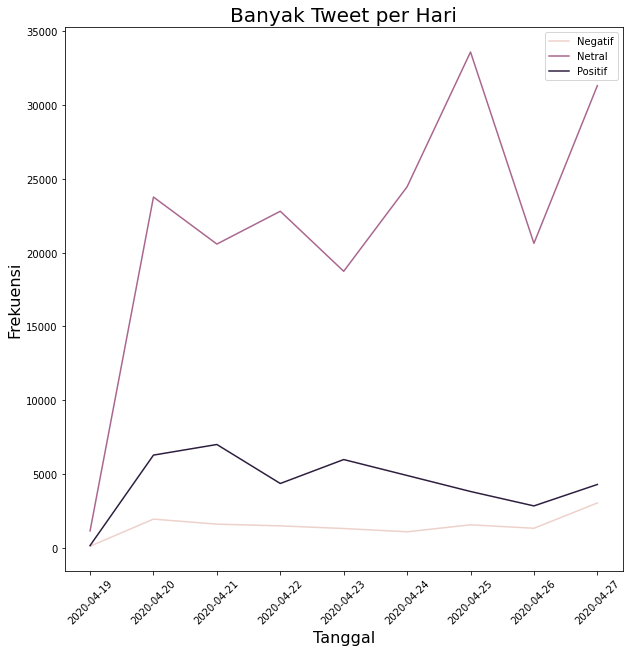

In [25]:
# Plotting line
plt.figure(figsize=(10, 10))
sns.lineplot(x="Tanggal", y="Frekuensi", hue="Sentiment", data=sent)
plt.title("Banyak Tweet per Hari", fontsize=20)
plt.xticks(rotation=45)
plt.xlabel("Tanggal", fontsize=16)
plt.ylabel("Frekuensi", fontsize=16)
plt.legend(["Negatif", "Netral", "Positif"])
plt.show()

**Insight**

Dapat dilihat dari diagram garis di atas bahwa pada rentang 19 - 27 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan netral jauh lebih banyak dan di susul oleh tweet yang bermuatan positif lalu tweet yang bermuatan netagtif. Dapat dilihat juga bahwa pada tanggal 25 April 2020 tweet yang bermuatan negatif jauh lebih banyak dari tweet yang bermuatan positif.

## 6. Penutup

Telah dilakukan Analisis Sentimen dan juga pemodelan terhadapa data hasil crawling. Data dipreprocess dan dilakukan vectorization menggunakan TF-IDF lalu dilakukan pemodelan. Dari berbagai model yang di uji didapatkan `SVM` adalah model dengan performa terbaik.

**Hal yang Dapat Dikembangkan**

1. Memperbanyak jumlah data yang dilakukan labeling secara manual
2. Melakukan hyperparameter tuning untuk mendapatkan hasil yang lebih maksimal
3. Menggunakan Boosting dalam pemodelan seperti, XGBoost, CatBoost, LGBM, dst.
4. Menggunakan metode Deep Learning

In [26]:
####################
## Saving Objects ##
####################

os.makedirs("../output", exist_ok=True)

# Export data baru
data.to_csv("../output/Data Sentiment Twitter 19 - 27 April.csv", index=False)

# Saving Model
for name, model in classifiers.items():
    pickle.dump(
        model,
        open(f"../output/[TRAINED] {name}_{datetime.today().strftime('%Y-%m-%d')}.pickle", "wb"),
    )

# Saving Vectorizer
pickle.dump(
    vectorizer_tfidf,
    open(f"../output/vectorizer_tfidf_{datetime.today().strftime('%Y-%m-%d')}.pickle", "wb"),
)